# BIOE70034 - Mathematical Methods for Neural Science and Engineering - Coursework 2

- Diane d'Haultfoeuille,
- Date : 15/12/2023

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import math
from scipy.special import factorial

# DATASET
dFonF1 = np.load("data/DFF_file3_ch1.npy")      # fluorescence time series ch1
nframes = np.size(dFonF1,1)
dFonF2 = np.load("data/DFF_file3_ch2.npy")      # channel 2
dFonF = np.concatenate((dFonF1,dFonF2[:,0:nframes])) # this now combines both channels
ncells = np.size(dFonF,0)
XY1 = np.load("data/coord_file3_ch1.npy")       # get coordinates of cells in space
XY2 = np.load("data/coord_file3_ch2.npy")
xc1 = XY1[0,:]
yc1 = XY1[1,:]
xc2 = XY2[0,:]
yc2 = XY2[1,:]
xc = np.hstack((xc1,xc2+1500))                  # xc,yc are your coords
yc = np.hstack((yc1,yc2))
fr = 7.6                                        # frame rate in Hz
t = np.linspace(0,(nframes-1)*1.0/fr,nframes)

For this coursework, we will use data that come from the first channel (left half of the image neurons).

# QUESTION 1

# 1.(a). Physical locations of the cells

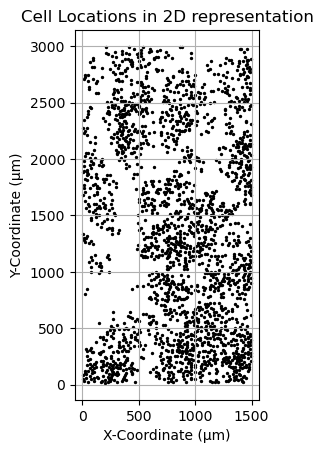

In [ ]:
#Visualise cell locations

# Plot the cells in a 2D representation
plt.scatter(xc1, yc1, 2, color='black')

# Set aspect ratio to be equal, so 1 mm on the x-axis is equal to 1 mm on the y-axis
plt.gca().set_aspect('equal')

plt.title('Cell Locations in 2D representation')
plt.xlabel('X-Coordinate (μm)')
plt.ylabel('Y-Coordinate (μm)')
plt.grid(True)
plt.show()

Given the information provided in the paper "Diesel2p mesoscope with dual independent scan engines for
flexible capture of dynamics in distributed neural circuitry" (Fig. 2.c), the coordinates of the cells are in μm.

Based on the graph, we can observe that the cells are not uniformly distributed. There are multiple regions of high cell density, in particular in the bottom (from 0 to 1500 μm) and the right side of the graph (from 0 to 1500 μm).

# 1.(b). Fluorescence time series for all cells

In order to be able to visualize pertinent information regarding the fluorescence time series of the cells, I have chosen to display the signal amplitude (i.e fluorescence intensity) only within the range of 0 to 1.5. This range seems appropriate since the majority of signal amplitude values fall within it. However, notice than the range of fluorenscence intensity of our data spans from -19.51 to 28.04.

Also, I plotted a zoom of the fluorescent time serie to better understand the behaviour of the cell over time.

In [ ]:
print("Minimum ΔF/F value: {:.4f}".format(np.min(dFonF1)))
print("Maximum ΔF/F value: {:.4f}".format(np.max(dFonF1)))

Minimum ΔF/F value: -19.5093
Maximum ΔF/F value: 28.0410


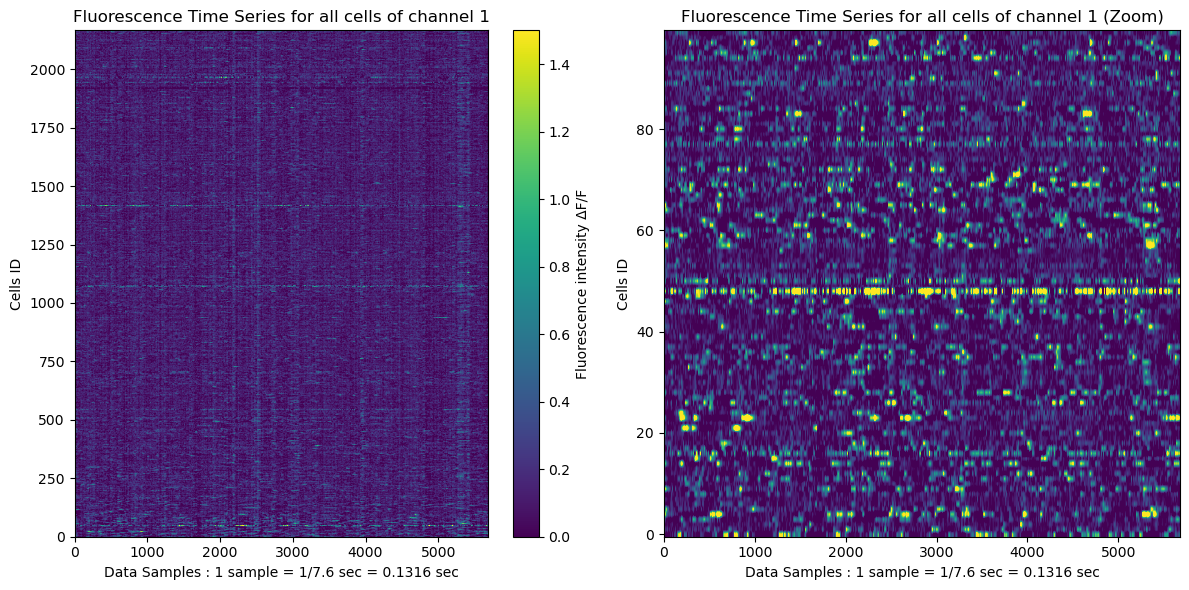

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the ΔF/F fluorescence time series as a matrix
im1 = axs[0].imshow(dFonF1, clim=[0, 1.5], aspect='auto', cmap='viridis', origin='lower')
axs[0].set_title('Fluorescence Time Series for all cells of channel 1')
axs[0].set_xlabel('Data Samples : 1 sample = 1/7.6 sec = 0.1316 sec')
axs[0].set_ylabel('Cells ID')
fig.colorbar(im1, ax=axs[0], label='Fluorescence intensity ΔF/F')

# Plot a zoom of the ΔF/F fluorescence time series
dFonF_zoom = dFonF1[0:100, :]
im2 = axs[1].imshow(dFonF_zoom, clim=[0, 1.5], aspect='auto', cmap='viridis', origin='lower')
axs[1].set_title('Fluorescence Time Series for all cells of channel 1 (Zoom)')
axs[1].set_xlabel('Data Samples : 1 sample = 1/7.6 sec = 0.1316 sec')
axs[1].set_ylabel('Cells ID')


plt.tight_layout()
plt.show()

The x-axis represent the number of samples taken over time. However, we know that the frame rate is 7.6Hz. This means that the system captures at a rate of 7.6 frames per second, so the time interval between each from is 1/7.6 = 0.1316 sec.

In the fluorescent time series plotted, we observed multiple coloured time points rather than continuous lines (easier to visualise in the zoomed graph). That means that the neural activity of the cells is not constant over time. There are periods of high activity (bright yellow points), followed by periods of low activity (dark purple points).

In the left graph, we can clearly see some brighter horizontal lines that shows that there are some cells more activated than the others. They are approximately located closed to cells 50, 1060, 1400 and 1900. We can also distinguished several vertical lines, with brighter ones located around 2200 and 2500 (time sample), as well as a larger one between 5300 and 5400 (time sample).

# 1.(c). Fluorescence time series for 5 cells

Different cells have been tested to see which one shown the most obvious calcium transients.

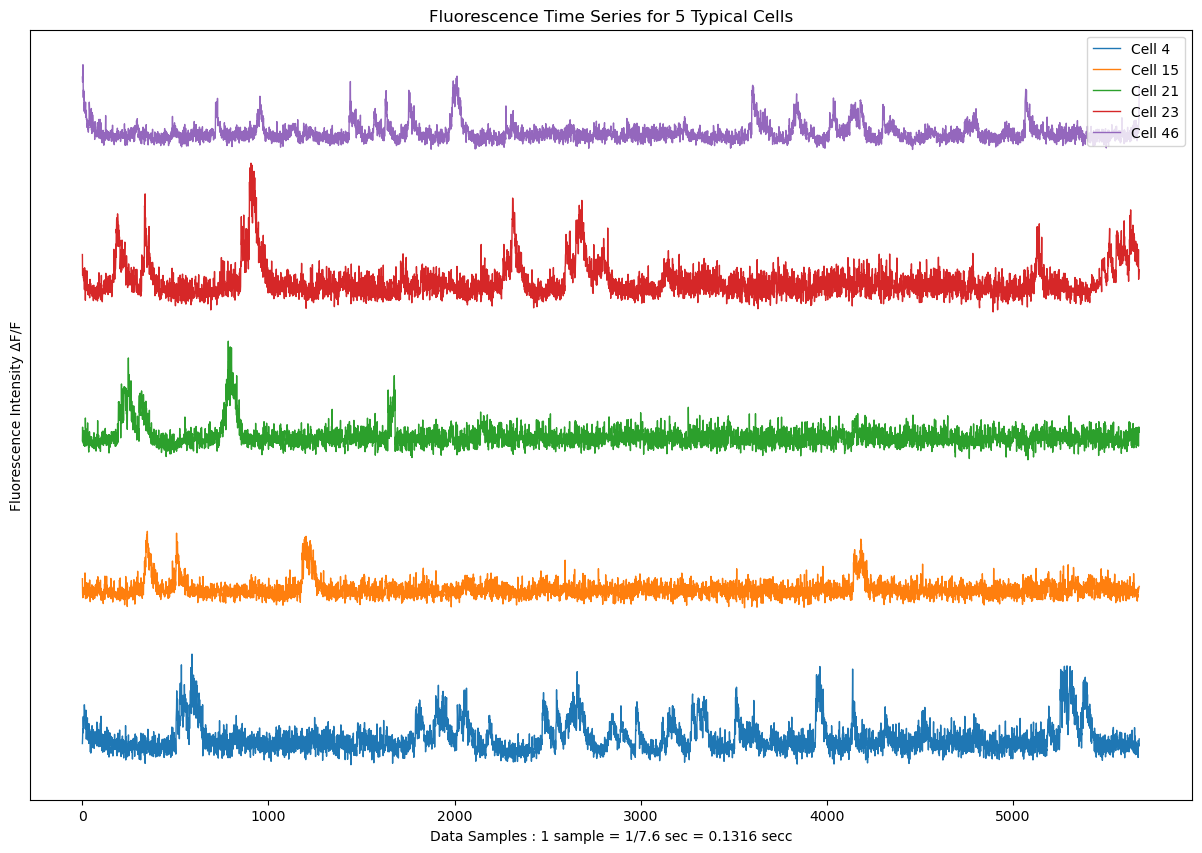

In [ ]:
selected_cells = [4,15,21,23,46]

# Plot the fluorescence time series for selected cells with vertical offsets
plt.figure(figsize=(15, 10))

for i, cell_idx in enumerate(selected_cells):
    trace = dFonF[cell_idx, :]
    offset = i*8
    plt.plot(trace + offset, label=f'Cell {cell_idx}', linewidth=1)

plt.title('Fluorescence Time Series for 5 Typical Cells')
plt.xlabel('Data Samples : 1 sample = 1/7.6 sec = 0.1316 secc')
plt.ylabel('Fluorescence Intensity ΔF/F')
# Hide tick marks and labels on the y-axis
plt.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.legend()
plt.show()

Upon examinating the 5 different fluorescent time series for each cell, we can observe for each curve multiple peaks over time. The peaks represent periods of increased activity of cells in the cortex.

For each cell, the intervals between peaks are irregular, showcasing a lack of periodicity. Also, the pattern between them are distinct. These variations suggest that cells do not respond uniformly to external stimuli, and thus they should not be involved in the same functions. Furthermore, the variability in the number of peaks among cells highlights significant differences in cell activation, with some cells exhibiting much higher activity (cell 4, 23 and 46) than others (cell 15 and 21).
The absence of outliers or abnormal drops in the dataset signifies the lack of anomalies.

# QUESTION 2 : Matrix of Pearson correlation coefficients

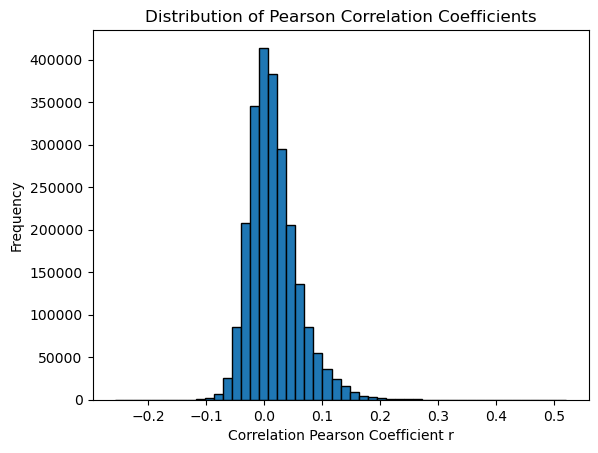

In [ ]:
#Calculate the matrix of Pearson correlation coefficients between the calcium fluorescence time series from each cell
corr_matrix = np.corrcoef(dFonF1)

# Extract the upper triangular part of the correlation matrix (excluding the diagonal)
corr_values = corr_matrix[np.triu_indices(corr_matrix.shape[0], k=1)]

# Plot the distribution of correlation coefficients
plt.hist(corr_values, bins=50, edgecolor='black')
plt.title('Distribution of Pearson Correlation Coefficients')
plt.xlabel('Correlation Pearson Coefficient r')
plt.ylabel('Frequency')
plt.show()

The histogram shows that the Pearson correlation coefficients between the calcium fluorescence time series from each cell varies between -0.3 to 0.5. However, most of the cells have no correlation between them, as the highest frequency corresponds to r = 0.0.

The following observation is consistent with the assumption made in question 1 : cells seem to respond to different stimulis, and thus do not have the same function and properties.

# Question 3 : Undirected graph network

# 3.(a).  Adjacency matrix

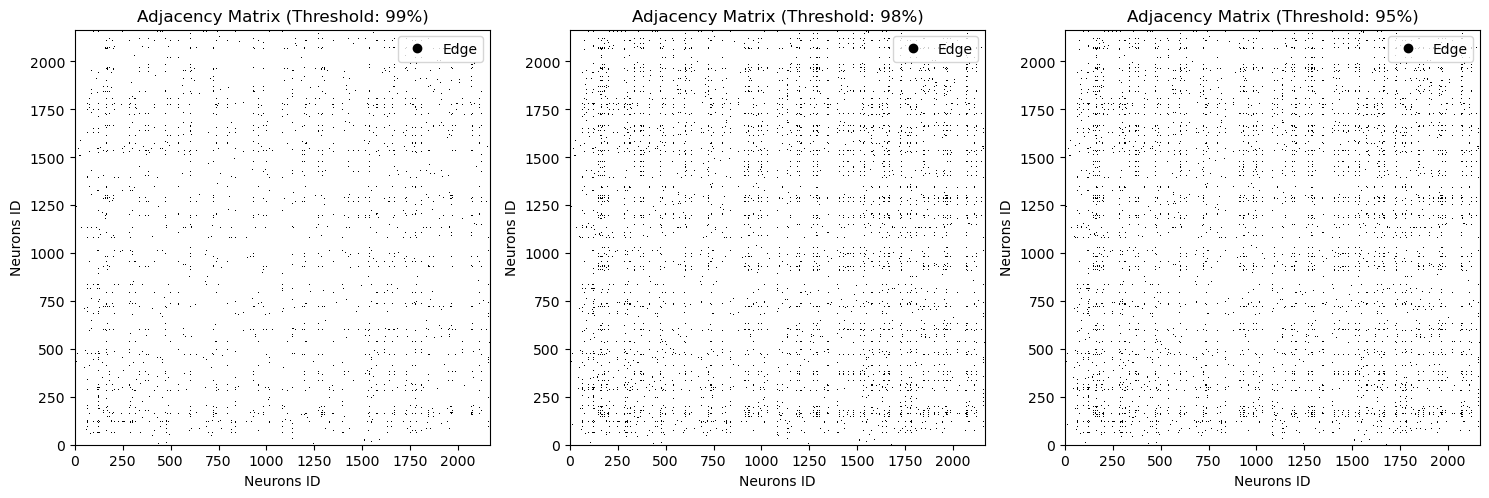

In [ ]:
def adj_matrix(threshold):
    # Calculate the threshold value based on the desired sparsity
    threshold_value = np.percentile(corr_values, threshold)

    #Create the adjacency matrix based on the threshold
    adjacency_matrix = np.where(corr_matrix > threshold_value, 1, 0)
    # Set diagonal elements to 0 to remove self-edges
    np.fill_diagonal(adjacency_matrix, 0)
    return adjacency_matrix

# Create a figure with 1 row and 3 columns for subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot the adjacency matrix for threshold=99
adj1 = adj_matrix(99)
axs[0].imshow(adj1, cmap='binary', interpolation='none', origin='lower')
axs[0].set_title(f'Adjacency Matrix (Threshold: 99%)')
axs[0].set_xlabel('Neurons ID')
axs[0].set_ylabel('Neurons ID')
axs[0].plot([], [], 'o', color='black', label='Edge')
axs[0].legend()

# Plot the adjacency matrix for threshold=98
adj2 = adj_matrix(98)
axs[1].imshow(adj2, cmap='binary', interpolation='none', origin='lower')
axs[1].set_title(f'Adjacency Matrix (Threshold: 98%)')
axs[1].set_xlabel('Neurons ID')
axs[1].set_ylabel('Neurons ID')
axs[1].plot([], [], 'o', color='black', label='Edge')
axs[1].legend()

# Plot the adjacency matrix for threshold=95
adj3 = adj_matrix(95)
axs[2].imshow(adj2, cmap='binary', interpolation='none', origin='lower')
axs[2].set_title(f'Adjacency Matrix (Threshold: 95%)')
axs[2].set_xlabel('Neurons ID')
axs[2].set_ylabel('Neurons ID')
axs[2].plot([], [], 'o', color='black', label='Edge')
axs[2].legend()


plt.tight_layout()
plt.show()

In [ ]:
num_edges1 = np.sum(adj1)
num_edges2 = np.sum(adj2)
num_edges3 = np.sum(adj3)

print(f'The number of edge between neurons for a threshold of 99%  is {num_edges1}.')
print(f'The number of edge between neurons for a threshold of 98%  is {num_edges2}.')
print(f'The number of edge between neurons for a threshold of 95%  is {num_edges3}.')

The number of edge between neurons for a threshold of 99%  is 46938.
The number of edge between neurons for a threshold of 98%  is 93876.
The number of edge between neurons for a threshold of 95%  is 234686.


The more we increase the threshold, the less is the number of edge between neurons. Indeed, the threshold is used to filter the connections between neurons. After many trials for question 3.b, a threshold of 98% seems to be the best choice if we want to be able to study the properties of the network with the graphical representation, without requiring too much memory to compute.

The visual analysis of the adjacency matrix reveals distinct patterns, notably characterized by horizontal and vertical white strips and clusters of dark points forming squares. These patterns suggest a non-uniform distribution of connections among neurons, indicating that certain neurons are more connected to each others in specific areas.

# 3.(b)

To represent the undirect graph, I choose to use the 2D representation of the cells and draw dark lines to represent the edge between them.

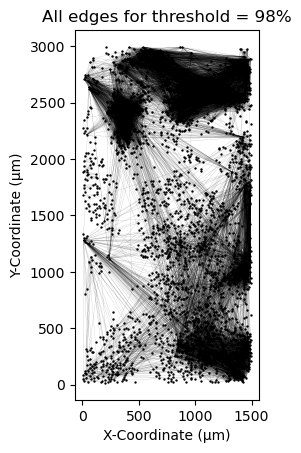

In [ ]:
num_neurons = corr_matrix.shape[0]
degree = np.sum(adj2,1)

#Create a neural network for adjacency matrix
plt.scatter(xc1, yc1, 0.5, color='black')
plt.gca().set_aspect('equal')
for i in range(num_neurons):
    for col in range(i,num_neurons):
        if (degree[i]>0):
            if (adj1[i,col]==1):
                plt.plot([xc1[i],xc1[col]],[yc1[i],yc1[col]], linewidth=0.05, color = 'k')

plt.title(f'All edges for threshold = 98%')
plt.xlabel('X-Coordinate (μm)')
plt.ylabel('Y-Coordinate (μm)')
plt.grid(False)
plt.show()

The undirect graph clearly highlights the areas where the neurons are strongly connected to each other and the area where there are less connection. In other words, it helps us to visual the clusters in the neural network.
If there is an edge between 2 neurons, it means that their calcium fluorescence time series are correlated, and thus their response activity are very similar (they respond to same stimulis). The areas showing clusters should be areas where the neurons have the same functions.

# Question 4

# Average degree

In [ ]:
L = (1/2)*np.sum(degree)
average_deg = 2*L/num_neurons

print(f'The average degree <k> for the network described by the above adjacency matrix adj2 is {average_deg:.2f}.')

The average degree <k> for the network described by the above adjacency matrix adj2 is 43.32.


An average degree of 43.32 suggests a relatively high level of connectivity in the network.
In comparison to a random network, this is likely higher, as random networks often have lower average degrees.

# Cluster coefficient

In [ ]:
edges = []
for vertex in range(num_neurons):
    temp = [i for i, x in enumerate(adj2[vertex,:]) if x == True]
    edges.append(list(temp))

closedtriangles = []
for vertex_i in range(num_neurons):
    count =0 # Reset the connections count
    #For each vertex_i
    if degree[vertex_i] <= 1:
        closedtriangles.append(0)
    else:
        for layer1 in edges[vertex_i]:
        #For the vertices that are connected to vertex_i (Layer 1)
            for layer2 in edges[layer1]:
                if layer2 in edges[vertex_i]:
                    # if a vertex  in the first layer is connected to another vertex in the first layer (which is connected to vertex i)
                    # Then the triangle between vertex i and its primary connections is closed
                    # So increase the count of closed triangles by 1
                    count = count +1

        closedtriangles.append(count/2)    # Divide by two to prevent double counting


nclosedtri = np.array(list(closedtriangles))
npossibletriangles = np.array(degree*(degree-1)/2) # calculate the # of possible triangles from each node

clustercoeff = np.zeros(num_neurons)  # Initialize cluster coefficients with zeros

for i in range(num_neurons):
    if npossibletriangles[i] != 0:  # Check if denominator is not zero
        clustercoeff[i] = nclosedtri[i] / npossibletriangles[i]  # Perform division

# Handle cases where npossibletriangles is zero (avoid division by zero)
clustercoeff[np.isnan(clustercoeff)] = 0

average_C = np.sum(clustercoeff)/num_neurons
print(f'The average cluster coefficient is {average_C:.2f}.')

global_C = np.sum(nclosedtri)/np.sum(npossibletriangles)
print(f'The global cluster coefficient is {global_C:.2f}.')

The average cluster coefficient is 0.45.
The global cluster coefficient is 0.57.


In [ ]:
C_ER = average_deg/(num_neurons-1)
print(f'Cluster coefficient for ER network (random network) : {C_ER:.2f}.')

Cluster coefficient for ER network (random network) : 0.02.


An average cluster coefficient of 0.45 and a global cluster coefficient of 0.57 are relatively high. This indicates a significant level of clustering.

For an Erdos-Renyi network, which is a good example of a random network, the clustering coefficient (for an undirected graph with no self-edges) should be equal to q = k/N-1. In our case, C = 0.02, which is indeed very low in comparaison with the coefficient found for our network.

# Network diameter D

In [ ]:
import networkx as nx

G = nx.from_numpy_array(adj2)
is_connected = nx.is_connected(G)
network_diameter = nx.diameter(G) if is_connected else float('inf')

print(f"Network Diameter: {network_diameter}")

Network Diameter: inf


Based on the return of the network diameter, our network is not fully connected. Then, we can't considerate our network as a "Small-word" network.
The characteristic for a "Small-World" network should be :

- Short average path length between nodes D, meaning that there is a quick communication across the network. Even if the network diameter D is low, the network should be fully connected.

- High cluster coefficient C

# Question 5: Degree distribution

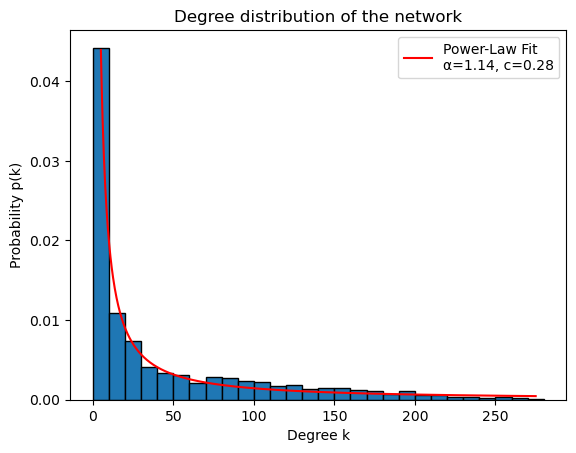

In [ ]:
from scipy.optimize import curve_fit

h, bin_edges = np.histogram(degree, bins='auto', density=True)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

# Define a power-law function
def power_law(x, alpha, c):
    return c * x**(-alpha)

# Fit the power-law function to the data
params, covariance = curve_fit(power_law, bin_centers, h)

# Plot the histogram
plt.hist(degree, bins='auto', density=True, edgecolor='black')

# Plot the fitted power-law curve
x_fit = np.linspace(min(bin_centers), max(bin_centers), 1000)
plt.plot(x_fit, power_law(x_fit, *params), color='red', label=f'Power-Law Fit\nα={params[0]:.2f}, c={params[1]:.2f}')

plt.title("Degree distribution of the network")
plt.xlabel("Degree k")
plt.ylabel("Probability p(k)")
plt.legend()
plt.show()

A scale-free network is a type of complex network characterized by a degree distribution that follows a power-law. This means that a few nodes, called "hubs," have a very high degree, while the majority of nodes have lower degrees.

We can consider our network as a scale-free network, as it follows the power-law f(k) = 0.28 * k^(1.14).
The exponent 1.14 indicates that the network has a relatively large number of hubs.

Furthermore, the histogram shows that the network as a maximum degree of around 250. Very few nodes in the network have a connection with 250 other nodes, while the majority of the nodes have nearly zero connection.

# Degree distribution predicted by an Erdös-Renyi network

We want to compare the degree distribution of our network with the one predicted by an Erdös-Renyi network of the same mean
degree.

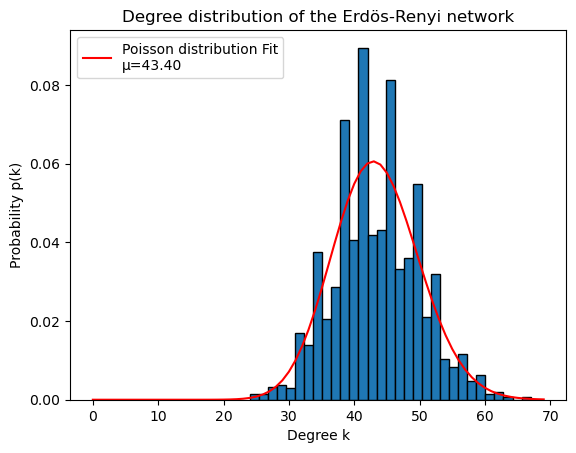

In [ ]:
q_undirected = average_deg/(num_neurons-1)

# undirected ER ADj matrix
udAdj = np.zeros([num_neurons,num_neurons])

for i in range(num_neurons):
    for j in range(i+1,num_neurons):
        if i!=j:
            if np.random.random() < q_undirected:
                udAdj[i,j] = 1
                udAdj[j,i] = 1

udavgDegree = np.sum(udAdj,1)
mean = np.mean(udavgDegree)

h = np.histogram(udavgDegree, bins='auto', density=True)

# Plot the histogram
plt.hist(udavgDegree, bins='auto', density=True, edgecolor='black')

def poisson(meank,k):
    return meank**k * math.exp(-1*meank)/math.factorial(k)

# Overlay the histogram with a poisson distribution with the same mean
x = np.array(range(0,70,1))
poi = []
for k in range(len(x)):
    poi.append(poisson(mean,k))
plt.plot(x,poi, color='red', label=f'Poisson distribution Fit\nμ={mean:.2f}')

plt.title("Degree distribution of the Erdös-Renyi network")
plt.xlabel("Degree k")
plt.ylabel("Probability p(k)")
plt.legend()
plt.show()

The histogram shows that the majority of nodes in the Erdos-Renyi network have a low degree, with two peaks at k1 ~ 40 and k2 ~ 46.

The x-axis of the histogram covers degree values between 0 and 80, which is lower than the k-values covers by the degree distribution of our network (scale-free) going from 0 to 250. However, the probabilities values goes from 0 to nearly 0.09, which is higher than the previous histogram (maximum value around 0.04).

Finally, we also found that for both network, the majority of the nodes have less than 50 connections with other nodes.

# References

C.-H. Yu, J. N. Stirman, Y. Yu, R. Hira and S.L. Smith, Diesel2p mesoscope with dual independent scan engines for
flexible capture of dynamics in distributed neural circuitry, Nature Communications 12:6639, 2021.